In [7]:
import pandas as pd
import numpy
import math

"""
Indoors is a class which represents the model calculation. A detailed description of
the mathematical model can be found at: Martin Z. Bazant and John W. M. Bush, medRxiv preprint (2020): 
"Beyond Six Feet: A Guideline to Limit Indoor Airborne Transmission of COVID-19"
http://web.mit.edu/bazant/www/COVID-19/
Properties:
Model Parameters
Calculated Variables
merv_dict: MERV values to aerosol filtration efficiency conversion
Methods:
def __init__: Constructor
def calc_vars: Calculates and stores all variables used in the model, based on the model parameters.
def calc_n_max: Calculate maximum people allowed in the room given an exposure time (hours), using the transient
                model.
def calc_n_max_ss: Calculate maximum people allowed in the room given an exposure time (hours), using the steady-state
                   model.
def calc_max_time: Calculate maximum exposure time allowed given a capacity (# people, transient)
def calc_n_max_series: Calculate maximum people allowed in the room across a range of exposure times
def get_six_ft_n: Get the maximum number of people allowed in the room, based on the six-foot rule.
def set_default_params: Sets default parameters.
def merv_to_eff: Converts a MERV rating to an aerosol filtration efficiency. 
def clamp: Clamps a value within a given range.
"""


class Indoors:
    # Model Parameters
    physical_params = []
    physio_params = []
    disease_params = []
    prec_params = []

    # Calculated Variables
    room_vol = 0  # ft3
    fresh_rate = 0  # ft3/min
    recirc_rate = 0  # ft3/min
    air_filt_rate = 0  # /hr
    sett_speed = 0  # m/hr
    conc_relax_rate = 0  # /hr
    airb_trans_rate = 0  # /hr
    viral_deact_rate = 0  # /hr
    eff_aerosol_radius = 0  # um

    # Source: https://www.ashrae.org/technical-resources/filtration-disinfection
    # Table of MERV values corresponding to aerosol filtration efficiency, by different particle sizes (in microns)
    merv_dict = [
        {'merv': 1, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.01},
        {'merv': 2, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.01},
        {'merv': 3, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.01},
        {'merv': 4, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.01},
        {'merv': 5, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.2},
        {'merv': 6, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.35},
        {'merv': 7, '0.3-1': 0.01, '1-3': 0.01, '3-10': 0.50},
        {'merv': 8, '0.3-1': 0.01, '1-3': 0.20, '3-10': 0.70},
        {'merv': 9, '0.3-1': 0.01, '1-3': 0.35, '3-10': 0.75},
        {'merv': 10, '0.3-1': 0.01, '1-3': 0.50, '3-10': 0.80},
        {'merv': 11, '0.3-1': 0.2, '1-3': 0.65, '3-10': 0.85},
        {'merv': 12, '0.3-1': 0.35, '1-3': 0.80, '3-10': 0.90},
        {'merv': 13, '0.3-1': 0.50, '1-3': 0.85, '3-10': 0.90},
        {'merv': 14, '0.3-1': 0.75, '1-3': 0.90, '3-10': 0.95},
        {'merv': 15, '0.3-1': 0.85, '1-3': 0.90, '3-10': 0.95},
        {'merv': 16, '0.3-1': 0.95, '1-3': 0.95, '3-10': 0.95},
        {'merv': 17, '0.3-1': 0.9997, '1-3': 0.9997, '3-10': 0.9997},
        {'merv': 18, '0.3-1': 0.99997, '1-3': 0.99997, '3-10': 0.99997},
        {'merv': 19, '0.3-1': 0.999997, '1-3': 0.999997, '3-10': 0.999997},
        {'merv': 20, '0.3-1': 0.9999997, '1-3': 0.9999997, '3-10': 0.9999997},
    ]

    def __init__(self):
        self.set_default_params()
        self.calc_vars()

    # Calculate all calculated variables
    def calc_vars(self):
        # Physical Parameters
        floor_area = self.physical_params[0]  # ft2
        mean_ceiling_height = self.physical_params[1]  # ft
        air_exch_rate = self.physical_params[2]  # /hr
        primary_outdoor_air_fraction = self.physical_params[3]  # no units
        aerosol_filtration_eff = self.physical_params[4]  # no units
        relative_humidity = self.physical_params[5]  # no units

        # Physiological Parameters
        breathing_flow_rate = self.physio_params[0]  # m3 / hr
        max_aerosol_radius = self.physio_params[1]

        # Disease Parameters
        exhaled_air_inf = self.disease_params[0]  # infection quanta/m3
        max_viral_deact_rate = self.disease_params[1]  # /hr

        # Precautionary Parameters
        mask_passage_prob = self.prec_params[0]  # no units

        # Calculation
        mean_ceiling_height_m = mean_ceiling_height * 0.3048
        self.room_vol = floor_area * mean_ceiling_height  # ft3
        room_vol_m = 0.0283168 * self.room_vol  # m3

        self.fresh_rate = self.room_vol * air_exch_rate / 60  # ft3/min

        self.recirc_rate = self.fresh_rate * (1/primary_outdoor_air_fraction - 1)  # ft3/min

        self.air_filt_rate = aerosol_filtration_eff * self.recirc_rate * 60 / self.room_vol  # /hr

        self.eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius

        self.viral_deact_rate = max_viral_deact_rate * relative_humidity

        self.sett_speed = 3 * (self.eff_aerosol_radius / 5) ** 2  # mm/s
        self.sett_speed = self.sett_speed * 60 * 60 / 1000  # m/hr

        self.conc_relax_rate = air_exch_rate + self.air_filt_rate + self.viral_deact_rate + self.sett_speed / mean_ceiling_height_m  # /hr

        self.airb_trans_rate = ((breathing_flow_rate * mask_passage_prob) ** 2) * exhaled_air_inf / (room_vol_m * self.conc_relax_rate)

    # Calculate maximum people allowed in the room given an exposure time (hours), using the
    # transient model
    def calc_n_max(self, exp_time):
        risk_tolerance = self.prec_params[1]  # no units
        n_max = 1 + (risk_tolerance * (1 + 1/(self.conc_relax_rate * exp_time)) / (self.airb_trans_rate * exp_time))
        return n_max

    # Calculate maximum people allowed in the room given an exposure time (hours), using the
    # steady-state model
    def calc_n_max_ss(self, exp_time):
        risk_tolerance = self.prec_params[1]  # no units
        n_max = 1 + risk_tolerance / (self.airb_trans_rate * exp_time)
        return n_max

    # Calculate maximum exposure time allowed given a capacity (# people), transient
    def calc_max_time(self, n_max):
        risk_tolerance = self.prec_params[1]  # no units

        exp_time_ss = risk_tolerance / ((n_max - 1) * self.airb_trans_rate)  # hrs, steady-state
        exp_time_trans = exp_time_ss * (1 + (1 + 4 / (self.conc_relax_rate * exp_time_ss)) ** 0.5) / 2  # hrs, transient
        return exp_time_trans

    # Calculate maximum people allowed in the room across a range of exposure times, returning both transient
    # and steady-state outputs
    def calc_n_max_series(self, t_min, t_max, t_step):
        df = pd.DataFrame(columns=['exposure_time', 'occupancy_trans', 'occupancy_ss'])
        for exp_time in numpy.arange(t_min, t_max, t_step):
            n_max_trans = self.calc_n_max(exp_time)
            n_max_ss = self.calc_n_max_ss(exp_time)
            df = df.append(pd.DataFrame({'exposure_time': [exp_time], 'occupancy_trans': [n_max_trans],
                                         'occupancy_ss': [n_max_ss]}))

        return df

    # Get the maximum number of people allowed in the room, based on the six-foot rule.
    def get_six_ft_n(self):
        floor_area = self.physical_params[0]  # ft2
        return math.floor(floor_area / 36)

    # Get the maximum number of people this room can physically have (based on floor area)
    def get_n_max(self):
        floor_area = self.physical_params[0]  # ft2
        flr_rad = 3  # ft
        return math.floor(floor_area / flr_rad ** 2)

    # Sets default parameters.
    def set_default_params(self):
        # Physical Parameters
        floor_area = 900  # ft2
        mean_ceiling_height = 12  # ft
        air_exchange_rate = 3  # /hr (air changes per hour (ACH))
        primary_outdoor_air_fraction = 0.2  # 1.0 = natural ventilation
        aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter
        relative_humidity = 0.6
        self.physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                                aerosol_filtration_eff, relative_humidity]

        # Physiological Parameters
        breathing_flow_rate = 0.5  # m3/hr
        max_aerosol_radius = 2  # micrometers
        self.physio_params = [breathing_flow_rate, max_aerosol_radius]

        # Disease Parameters
        exhaled_air_inf = 30  # infection quanta/m3
        max_viral_deact_rate = 0.3  # /hr
        self.disease_params = [exhaled_air_inf, max_viral_deact_rate]

        # Precautionary Parameters
        mask_passage_prob = 0.1  # 1 = no masks, ~0.1 cloth, <0.05 N95
        risk_tolerance = 0.1  # expected transmissions per infector
        self.prec_params = [mask_passage_prob, risk_tolerance]

    # Convert MERV rating to aerosol filtration efficiency
    # merv: if not integer, floor it
    # aerosol_radius: must be <= 10
    @staticmethod
    def merv_to_eff(merv, aerosol_radius):
        if merv == 0:
            return 0
        eff = 0
        merv = numpy.floor(Indoors.clamp(merv, 1, 20))
        merv_dict = Indoors.merv_dict
        for item in merv_dict:
            if item['merv'] == merv:
                if aerosol_radius < 1:
                    eff = item['0.3-1']
                elif aerosol_radius < 3:
                    eff = item['1-3']
                else:
                    eff = item['3-10']

        return eff

    # Clamp value within range
    @staticmethod
    def clamp(n, smallest, largest):
        return max(smallest, min(n, largest))

In [46]:
"""
This program uses and adapts code for Aerosol transmission developed by kawesomekhan based on the 
model developed by Bazant et. al. at the Massachussets Institute of Techology (MIT).

A detailed description of the mathematical model can be found at: Martin Z. Bazant and John W. M. Bush, 
medRxiv preprint (2020): "Beyond Six Feet: A Guideline to Limit Indoor Airborne Transmission of COVID-19"

***************************************************************************************
*    Title: Indoors.py
*    Author: @kawesomekhan 
*    Date: 01/17/2021
*    Code version: 1.0 (Commit ID: 7c59dd5edce43b8e860059e61e2a9b520b637515)
*    Availability: https://github.com/kawesomekhan/covid-indoor/blob/master/indoors.py
***************************************************************************************
"""

import pandas as pd
import numpy as np


floor_area = 900  # ft2
mean_ceiling_height = 12  # ft
air_exchange_rate = 3  # /hr (air changes per hour (ACH))

##Assumed Parameter Identified as 0.2 for Classrooms, 1.0 for outdoors##
primary_outdoor_air_fraction = 0.2  # 1.0 = natural ventilation
aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter

#Average daily RH for San Diego is 69%
relative_humidity = 0.69
physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                        aerosol_filtration_eff, relative_humidity]

# Physiological Parameters
breathing_flow_rate = 0.5  # m3/hr
max_aerosol_radius = 2  # micrometers
physio_params = [breathing_flow_rate, max_aerosol_radius]

# Disease Parameters
exhaled_air_inf = 30  # infection quanta/m3, changes with acitivity type.
max_viral_deact_rate = 0.3  # /hr
disease_params = [exhaled_air_inf, max_viral_deact_rate]

# Precautionary Parameters
mask_passage_prob = 1 # 1 = no masks, ~0.1 cloth, <0.05 N95
risk_tolerance = 0.1  # expected transmissions per infector
prec_params = [mask_passage_prob, risk_tolerance]

In [63]:
%%writefile aerosol.py

def return_aerosol_transmission_rate(floor_area, room_height,
                            air_exchange_rate, 
                            aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
                            exhaled_air_inf, max_viral_deact_rate, mask_passage_prob, 
                            max_aerosol_radius=2, primary_outdoor_air_fraction=0.2):
    
    mean_ceiling_height_m = mean_ceiling_height * 0.3048 #m3
    room_vol = floor_area * mean_ceiling_height  # ft3
    room_vol_m = 0.0283168 * room_vol  # m3

    fresh_rate = room_vol * air_exchange_rate / 60  # ft3/min
    recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)  # ft3/min
    air_filt_rate = aerosol_filtration_eff * recirc_rate * 60 / room_vol  # /hr
    eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
    viral_deact_rate = max_viral_deact_rate * relative_humidity
    sett_speed = 3 * (eff_aerosol_radius / 5) ** 2  # mm/s
    sett_speed = sett_speed * 60 * 60 / 1000  # m/hr
    conc_relax_rate = air_exchange_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m  # /hr
    airb_trans_rate = ((breathing_flow_rate * mask_passage_prob) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate)
    
    return airb_trans_rate #This is mean number of transmissions per hour between pair of infected / healthy individuals


def aerosol_infection_probability(classroom, interventions=None):
    #Calculate mean breathing rate of kids in the room (activity dependent)
    
    #Calculate mean viral exhalation rate in the room 
    
    #Choose specific intervention pattern
    
    #Pass parameters along to return_aerosol_transmission_rate function
    
    #Multiply probability by the number of infected individuals in the room.
    
    # Return number/infect
    pass
    

Overwriting aerosol.py


In [65]:
! code aerosol.py

In [62]:
def aerosol_infection_probability(classroom, interventions=None):
    #Calculate mean breathing rate of kids in the room (activity dependent)
    
    #Calculate mean viral exhalation rate in the room 
    
    #Choose specific intervention pattern
    
    #Pass parameters along to return_aerosol_transmission_rate function
    
    # Multiply probability by the number of infected individuals in the room.
    
    # Return number/infect
    pass
    

In [27]:
mean_ceiling_height_m = mean_ceiling_height * 0.3048 #m3
room_vol = floor_area * mean_ceiling_height  # ft3
room_vol_m = 0.0283168 * room_vol  # m3


fresh_rate = room_vol * air_exchange_rate / 60  # ft3/min
recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)  # ft3/min
air_filt_rate = aerosol_filtration_eff * recirc_rate * 60 / room_vol  # /hr
eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
viral_deact_rate = max_viral_deact_rate * relative_humidity
sett_speed = 3 * (eff_aerosol_radius / 5) ** 2  # mm/s
sett_speed = sett_speed * 60 * 60 / 1000  # m/hr
conc_relax_rate = air_exchange_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m  # /hr
airb_trans_rate = ((breathing_flow_rate * mask_passage_prob) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate)

In [66]:
def calc(air_exchange_rate):
    mean_ceiling_height_m = mean_ceiling_height * 0.3048 #m3
    room_vol = floor_area * mean_ceiling_height  # ft3
    room_vol_m = 0.0283168 * room_vol  # m3
    fresh_rate = room_vol * air_exchange_rate / 60  # ft3/min
    recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)  # ft3/min
    air_filt_rate = aerosol_filtration_eff * recirc_rate * 60 / room_vol  # /hr
    eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
    viral_deact_rate = max_viral_deact_rate * relative_humidity
    sett_speed = 3 * (eff_aerosol_radius / 5) ** 2  # mm/s
    sett_speed = sett_speed * 60 * 60 / 1000  # m/hr
    conc_relax_rate = air_exchange_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m  # /hr
    airb_trans_rate = ((breathing_flow_rate * mask_passage_prob) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate)
    
    return airb_trans_rate

In [67]:
air_exchange_rates = pd.Series(np.arange(0.3, 30, 0.01))

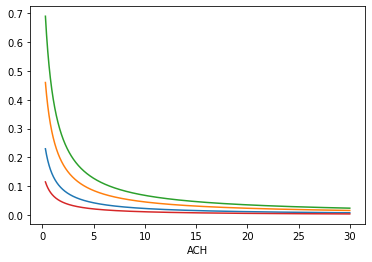

In [78]:
import matplotlib.pyplot as plt
#air_exchange_rates.apply(calc).plot()
plt.plot(np.arange(0.3, 30, 0.01), air_exchange_rates.apply(calc).values*10)
plt.plot(np.arange(0.3, 30, 0.01), air_exchange_rates.apply(calc).values*20)
plt.plot(np.arange(0.3, 30, 0.01), air_exchange_rates.apply(calc).values*30)
plt.plot(np.arange(0.3, 30, 0.01), air_exchange_rates.apply(calc).values*5)
plt.xlabel('ACH')
plt.savefig('ACH.png',dpi=1000)